In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

main_seed = 42

np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)


<ipython-input-1-22e8cc04668c>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [ ]:
import torch

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/Mini-projects'

# Load data

In [ ]:
import pickle
import gzip

# load data from preprocessing file
def load_data(file_name):
  global base_path
  with gzip.open(os.path.join(base_path, file_name), 'rb') as f:
    return pickle.load(f)

In [ ]:
# load all values
X_train = load_data('X_train_word.pickle')
X_val = load_data('X_val_word.pickle')
X_test = load_data('X_test_word.pickle')

y_train = load_data('y_train.pickle')
y_val = load_data('y_val.pickle')
y_test = load_data('y_test.pickle')

embeddings = load_data('embeddings.pickle')

max_len = load_data('max_len.pickle')


In [ ]:
# function to show loss and accuracy changes in the models
def show_history(model_hist):
  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.plot(model_hist.history['loss'], 'b', label='train')
  plt.plot(model_hist.history['val_loss'], 'g', label='val')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend(loc='upper right')

  plt.subplot(122)
  plt.plot(model_hist.history['accuracy'], 'b', label='train')
  plt.plot(model_hist.history['val_accuracy'], 'g', label='val')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc='upper left')

  plt.show();

In [ ]:
import keras
import keras.backend as K
from keras.layers import Input, Embedding, LSTM, Lambda, concatenate, Dropout, Flatten, Dense, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D
from keras.models import Model
from keras import initializers
from sklearn.metrics import accuracy_score, f1_score

np.random.seed(main_seed)
tf.random.set_seed(main_seed)

In [ ]:
# stop early save the best results to local drive
def set_callbacks(model_name):
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=2)

  base_path = '/content/drive/MyDrive/Mini-projects'
  file_path = os.path.join(base_path,
                           'model_result',
                           model_name + '_weight.hdf5')
  save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    option=None)

  return early_stop, save_best, file_path

In [ ]:
# stop early save the best results to local gg colab
def set_callbacks_ver2(model_name):
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=2)

  file_path = os.path.join(model_name + '_weight.hdf5')
  save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    option=None)

  return early_stop, save_best, file_path

# MaLSTM

In [ ]:
# exponent neg manhattan distance
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))


In [ ]:
def create_MaLSTM(max_length):
  #input layer
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))


  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # lstm
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed))
  left_output = lstm_layer(left_encoded)
  right_output = lstm_layer(right_encoded)

  # calculate exponent_neg_manhattan_distance (value 0 -> 1)
  distance = Lambda(function = lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                    output_shape = lambda x: (x[0][0], 1)
                    )([left_output, right_output])

  model = Model([left_input, right_input], [distance])
  return model

In [ ]:
malstm = create_MaLSTM(max_len)

malstm.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
malstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 300)              8424000   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 50)                   70200     ['embedding[0][0]',       

In [ ]:
#convert to tensor
temp_s1 = []
temp_s2 = []
for i in range(3576):
  x_train_s1 = X_train['sentence1'].values[i].tolist()
  x_train_s2 = X_train['sentence2'].values[i].tolist()
  if len(x_train_s1) == 30 and len(x_train_s2) == 30:
    temp_s1.append(x_train_s1)
    temp_s2.append(x_train_s2)

temp_s1 = np.array(temp_s1)
temp_s2 = np.array(temp_s2)
x_train_s1_tensor = torch.from_numpy(temp_s1)
x_train_s2_tensor= torch.from_numpy(temp_s2)

temp_s1 = []
temp_s2 = []
for i in range(500):
  x_val_s1 = X_val['sentence1'].values[i].tolist()
  x_val_s2 = X_val['sentence2'].values[i].tolist()
  if len(x_val_s1) == 30 and len(x_val_s2) == 30:
    temp_s1.append(x_val_s1)
    temp_s2.append(x_val_s2)

temp_s1 = np.array(temp_s1)
temp_s2 = np.array(temp_s2)
x_val_s1_tensor = torch.from_numpy(temp_s1)
x_val_s2_tensor= torch.from_numpy(temp_s2)

temp_s1 = []
temp_s2 = []
for i in range(1725):
  x_test_s1 = X_test['sentence1'].values[i].tolist()
  x_test_s2 = X_test['sentence2'].values[i].tolist()
  if len(x_test_s1) == 30 and len(x_test_s2) == 30:
    temp_s1.append(x_test_s1)
    temp_s2.append(x_test_s2)

temp_s1 = np.array(temp_s1)
temp_s2 = np.array(temp_s2)
x_test_s1_tensor = torch.from_numpy(temp_s1)
x_test_s2_tensor= torch.from_numpy(temp_s2)

In [ ]:
x_test_s1_tensor

tensor([[22607,  2273,  2809,  ...,     0,     0,     0],
        [   83,  6774,   366,  ...,     0,     0,     0],
        [ 4916,    24,   420,  ...,     0,     0,     0],
        ...,
        [28078,  1260,  3084,  ...,     0,     0,     0],
        [  668,  1158,    24,  ...,     0,     0,     0],
        [ 3988,  3975,   255,  ...,     0,     0,     0]])

In [ ]:
x_val_s2_tensor

tensor([[ 7089,   588,   131,  ...,     0,     0,     0],
        [20879,    42, 16950,  ...,     0,     0,     0],
        [20882,   166, 20881,  ...,     0,     0,     0],
        ...,
        [ 1293,  3591,    24,  ...,     0,     0,     0],
        [22604,   106,   716,  ...,     0,     0,     0],
        [   83,  5041,  5042,  ...,     0,     0,     0]])

In [ ]:
x_train_s1_np = x_train_s1_tensor.numpy()
x_train_s2_np = x_train_s2_tensor.numpy()

# Convert NumPy arrays to TensorFlow tensors with the correct data type
x_train_s1_tf = tf.convert_to_tensor(x_train_s1_np, dtype=tf.int32)
x_train_s2_tf = tf.convert_to_tensor(x_train_s2_np, dtype=tf.int32)


x_val_s1_np = x_val_s1_tensor.numpy()
x_val_s2_np = x_val_s2_tensor.numpy()

# Convert NumPy arrays to TensorFlow tensors with the correct data type
x_val_s1_tf = tf.convert_to_tensor(x_val_s1_np, dtype=tf.int32)
x_val_s2_tf = tf.convert_to_tensor(x_val_s2_np, dtype=tf.int32)

x_test_s1_np = x_test_s1_tensor.numpy()
x_test_s2_np = x_test_s2_tensor.numpy()

# Convert NumPy arrays to TensorFlow tensors with the correct data type
x_test_s1_tf = tf.convert_to_tensor(x_test_s1_np, dtype=tf.int32)
x_test_s2_tf = tf.convert_to_tensor(x_test_s2_np, dtype=tf.int32)

In [ ]:
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test = y_test.astype('int32')

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks('MaLSTM')

malstm_history = malstm.fit(
    [x_train_s1_tf, x_train_s2_tf],
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=([x_val_s1_tf, x_val_s2_tf], y_val),
    callbacks=[save_best, early_stop]);


Epoch 1/20
109/112 [============================>.] - ETA: 0s - loss: 0.8151 - accuracy: 0.5315
Epoch 1: val_loss improved from inf to 0.73906, saving model to /content/drive/MyDrive/Mini-projects/model_result/MaLSTM_weight.hdf5
112/112 [==============================] - 14s 33ms/step - loss: 0.8152 - accuracy: 0.5319 - val_loss: 0.7391 - val_accuracy: 0.5760
Epoch 2/20
105/112 [===========================>..] - ETA: 0s - loss: 0.6488 - accuracy: 0.6405
Epoch 2: val_loss improved from 0.73906 to 0.71004, saving model to /content/drive/MyDrive/Mini-projects/model_result/MaLSTM_weight.hdf5
112/112 [==============================] - 1s 9ms/step - loss: 0.6500 - accuracy: 0.6398 - val_loss: 0.7100 - val_accuracy: 0.5920
Epoch 3/20
109/112 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7308
Epoch 3: val_loss did not improve from 0.71004
112/112 [==============================] - 1s 8ms/step - loss: 0.5388 - accuracy: 0.7321 - val_loss: 0.7109 - val_accuracy: 0.5960


In [ ]:
# validation dataset accuracy, f1_score

%%time
malstm.load_weights(file_path)
y_pred = malstm.predict([x_test_s1_tf, x_test_s2_tf])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_test, y_pred_class))
print('val f1_score:', f1_score(y_test, y_pred_class))

54/54 [==============================] - 1s 5ms/step
val accuracy: 0.6075362318840579
val f1_score: 0.7147071217867677
CPU times: user 1.15 s, sys: 85.9 ms, total: 1.24 s
Wall time: 2.74 s


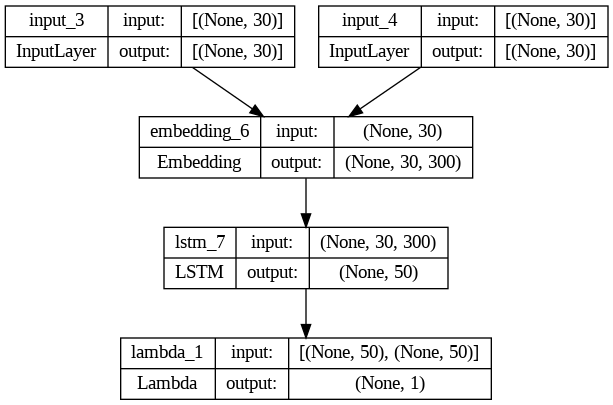

In [ ]:
from keras.utils import plot_model
plot_model(malstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


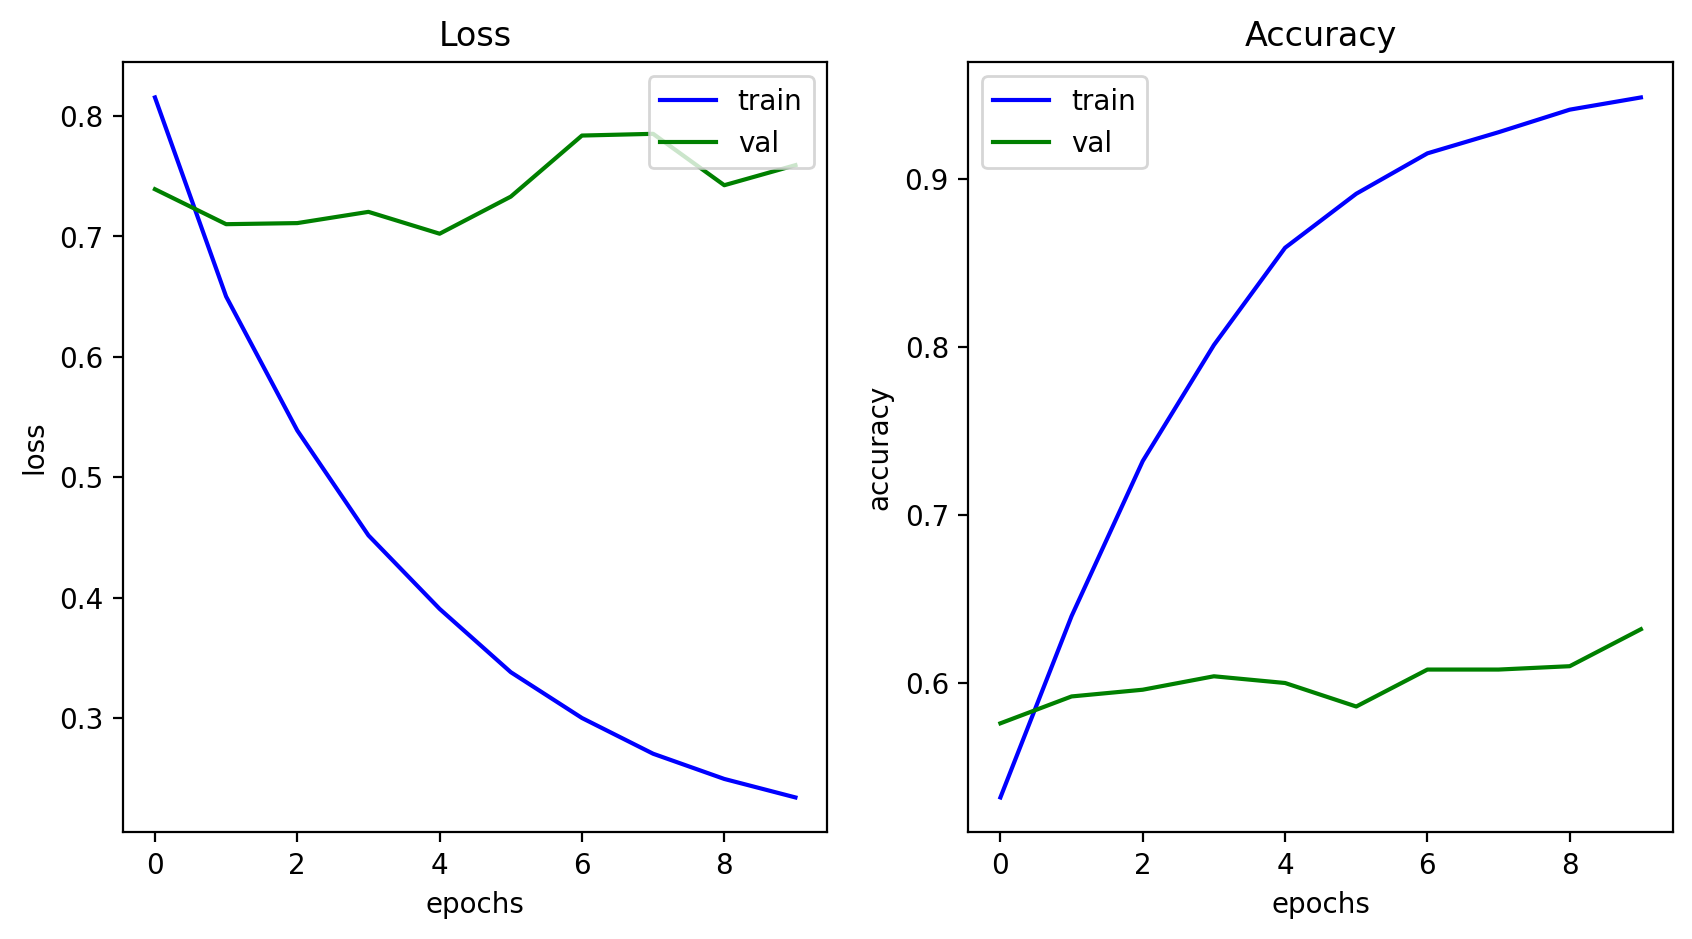

In [ ]:
malstm.save(os.path.join(base_path, 'model_result', 'MaLSTM.h5'))
show_history(malstm_history)

# CNN + LSTM

In [ ]:
def create_CNN_LSTM(max_length):

  # input layer
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))


  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)


  # LSTM
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                    bias_initializer=initializers.Constant(value=2.5),
                    return_sequences=True)
  left_output = lstm_layer(left_output)
  right_output = lstm_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)


# exponent_neg_manhattan_distance
  distance = Lambda(function = lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                    output_shape = lambda x: (x[0][0], 1)
                    )([left_output, right_output])

  model = Model([left_input, right_input], [distance])
  return model

In [ ]:
cnnlstm = create_CNN_LSTM_FC(max_len)

cnnlstm.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnnlstm.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 30, 300)              8424000   ['input_29[0][0]',            
                                                                     'input_30[0][0]']            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 30, 300)              270300    ['embedding_14[0][0]', 

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_LSTM')

cnnlstm_history = cnnlstm.fit(
    [x_train_s1_tf, x_train_s2_tf],
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=([x_val_s1_tf, x_val_s2_tf], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
106/112 [===========================>..] - ETA: 0s - loss: 0.6124 - accuracy: 0.6645
Epoch 1: val_loss improved from inf to 0.57881, saving model to CNN1D_LSTM_weight.hdf5
112/112 [==============================] - 6s 17ms/step - loss: 0.6125 - accuracy: 0.6644 - val_loss: 0.5788 - val_accuracy: 0.6980
Epoch 2/20
109/112 [============================>.] - ETA: 0s - loss: 0.5551 - accuracy: 0.7081
Epoch 2: val_loss improved from 0.57881 to 0.56797, saving model to CNN1D_LSTM_weight.hdf5
112/112 [==============================] - 1s 9ms/step - loss: 0.5562 - accuracy: 0.7064 - val_loss: 0.5680 - val_accuracy: 0.7020
Epoch 3/20
112/112 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.7383
Epoch 3: val_loss did not improve from 0.56797
112/112 [==============================] - 1s 8ms/step - loss: 0.5286 - accuracy: 0.7383 - val_loss: 0.5776 - val_accuracy: 0.6900
Epoch 4/20
106/112 [===========================>..] - ETA: 0s - loss: 0.5054 - accuracy: 0.76

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnlstm.load_weights(file_path)
y_pred = cnnlstm.predict([x_test_s1_tf, x_test_s2_tf])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_test, y_pred_class))
print('val f1_score:', f1_score(y_test, y_pred_class))

54/54 [==============================] - 1s 4ms/step
val accuracy: 0.7002898550724638
val f1_score: 0.8057121382938744
CPU times: user 1 s, sys: 68.9 ms, total: 1.07 s
Wall time: 1.01 s


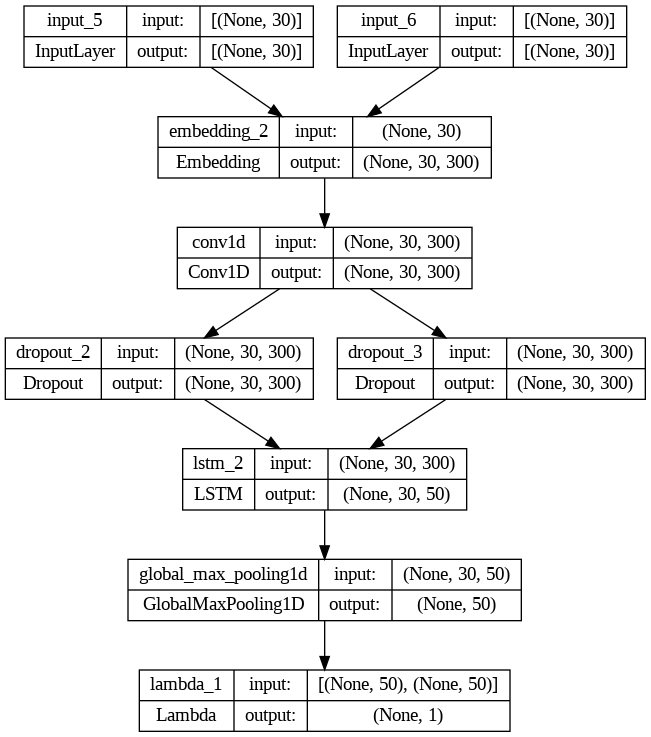

In [ ]:
plot_model(cnnlstmfc, to_file='cnnlstm.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


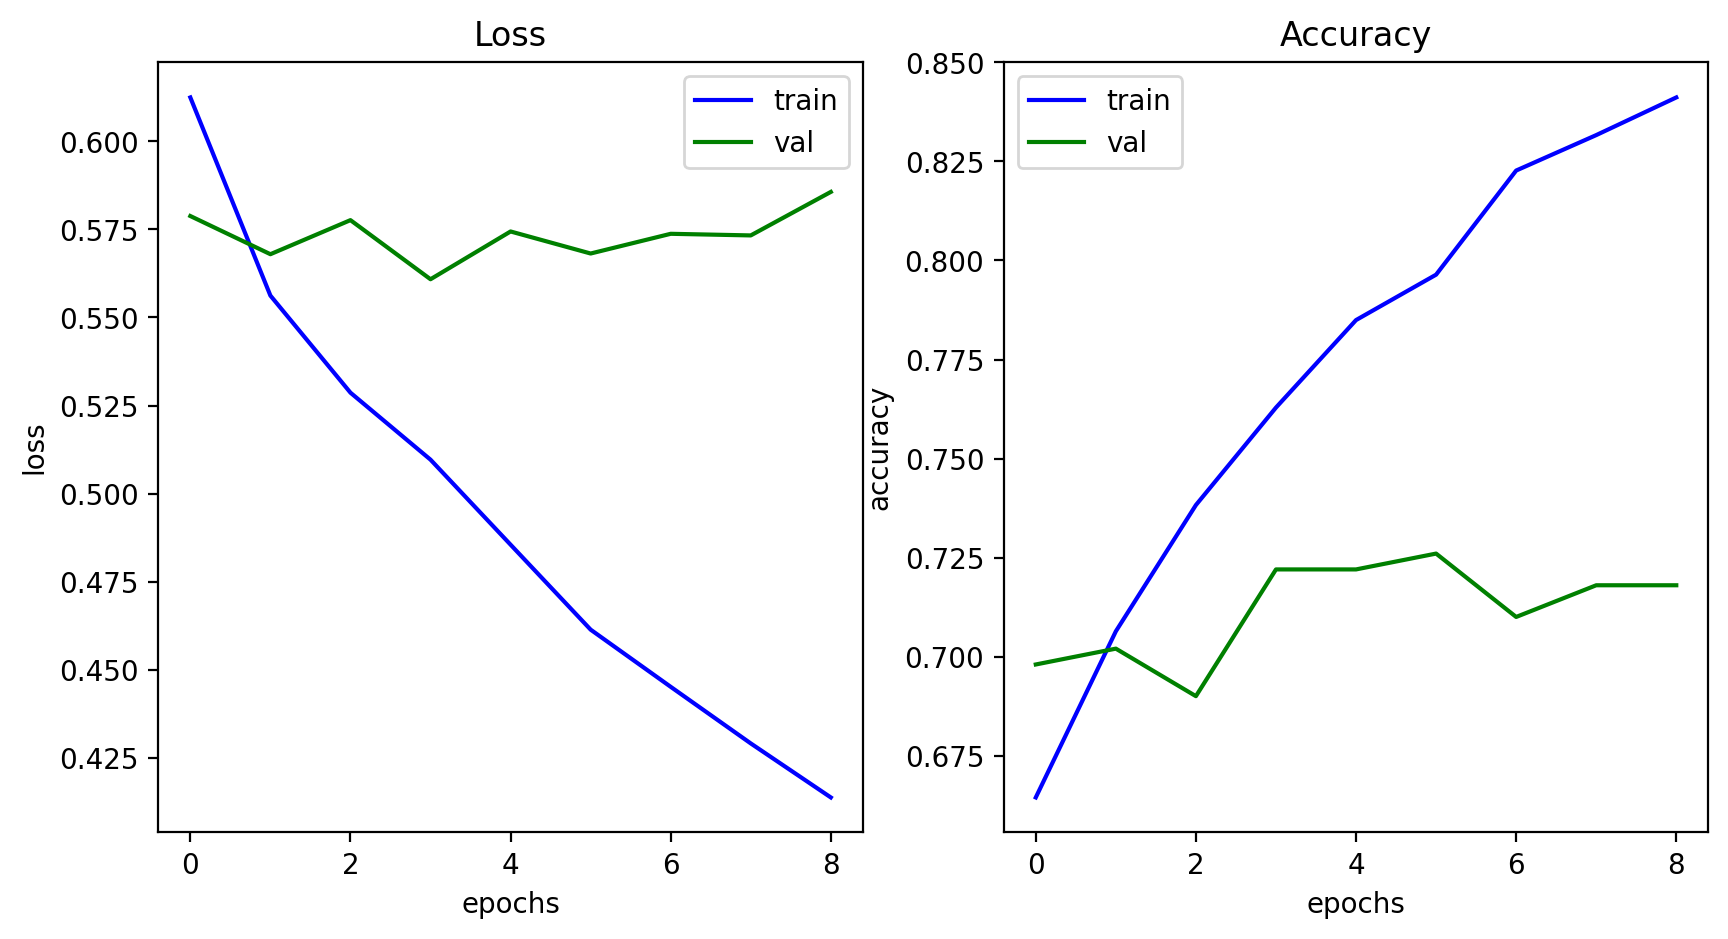

In [ ]:
cnnlstm.save(os.path.join(base_path, 'model_result', 'CNN1D_LSTM.h5'))
show_history(cnnlstm_history)